In [28]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch

from sklearn.preprocessing import LabelEncoder

import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

np.random.seed(101)
shap.initjs()

In [29]:
df = pd.read_csv('dataset.csv')
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 57 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   switch-type                          1053 non-null   object 
 1   max-memory-inhibit                   1053 non-null   bool   
 2   max-sym-array-size                   1053 non-null   int64  
 3   max-depth                            1053 non-null   int64  
 4   watchdog                             1053 non-null   bool   
 5   max-static-fork-pct                  1053 non-null   float64
 6   const-array-opt                      1053 non-null   bool   
 7   zero-seed-extension                  1053 non-null   bool   
 8   smtlib-display-constants             1053 non-null   object 
 9   warnings-only-to-file                1053 non-null   bool   
 10  smtlib-human-readable                1053 non-null   bool   
 11  warn-all-external-symbols     

,switch-type,max-memory-inhibit,max-sym-array-size,max-depth,watchdog,max-static-fork-pct,const-array-opt,zero-seed-extension,smtlib-display-constants,warnings-only-to-file,...,cex-cache-superset,verify-each,max-memory,batch-time,max-static-solve-pct,max-static-cpfork-pct,max-static-cpsolve-pct,array-value-symb-ratio,sym-stdin,Coverage
0,internal,False,3980,1142,True,0.159269,True,False,bin,False,...,False,False,1136,4.0,0.392040,0.197067,0.029739,0.896605,4,0
1,llvm,True,6067,2189,True,0.798309,True,True,bin,False,...,False,True,2040,7.0,0.848477,0.372759,0.209427,0.780304,11,1850
2,llvm,False,3104,646,True,0.238140,True,False,dec,True,...,False,True,1098,4.0,0.922272,0.613608,0.533229,0.582163,4,2562
3,internal,False,5791,1579,False,0.641675,False,True,dec,False,...,False,False,1242,6.0,0.464663,0.849170,0.521843,0.401757,4,1296
4,internal,True,2356,537,True,0.893913,False,True,bin,True,...,True,True,711,4.0,0.538513,0.410924,0.766638,0.351363,8,1281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,simple,False,329279,181009,True,0.480900,False,False,bin,True,...,True,False,59068,8.0,0.926000,0.766700,0.604200,0.059100,19,1396
1049,simple,True,199941,1376,False,0.959500,False,False,hex,True,...,True,False,44955,4.0,0.377300,0.849700,0.431100,0.802000,50,1866
1050,simple,False,196349,153606,True,0.008200,True,False,dec,False,...,False,True,46454,4.0,0.844500,0.783000,0.138100,0.579200,29,1939
1051,internal,False,5548,2335,True,0.803200,True,False,dec,False,...,True,True,59204,44.0,0.178000,0.014700,0.957900,0.110700,16,1686


In [30]:
# LabelEncoder를 사용하여 문자열 변수를 숫자로 변환
le = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object']).columns

for column in categorical_columns:
    df[column] = le.fit_transform(df[column])

boolean_columns = df.select_dtypes(include=['bool']).columns

for column in boolean_columns:
    df[column] = df[column].astype(int)

scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns 
numerical_columns = numerical_columns.drop('Coverage')
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# 입력 변수와 타겟 변수 분리
X = df.drop('Coverage', axis=1)
y = df['Coverage']

# 데이터를 train/val/test 세트로 분할 (비율: 7:2:1)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (757, 56) (757,)
Validation set shape: (190, 56) (190,)
Test set shape: (106, 56) (106,)


In [34]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [35]:
# 모델 예측 성능 평가
score = model.score(X_test, y_test)
print(f'Model R^2 score: {score:.3f}')

Model R^2 score: 0.041


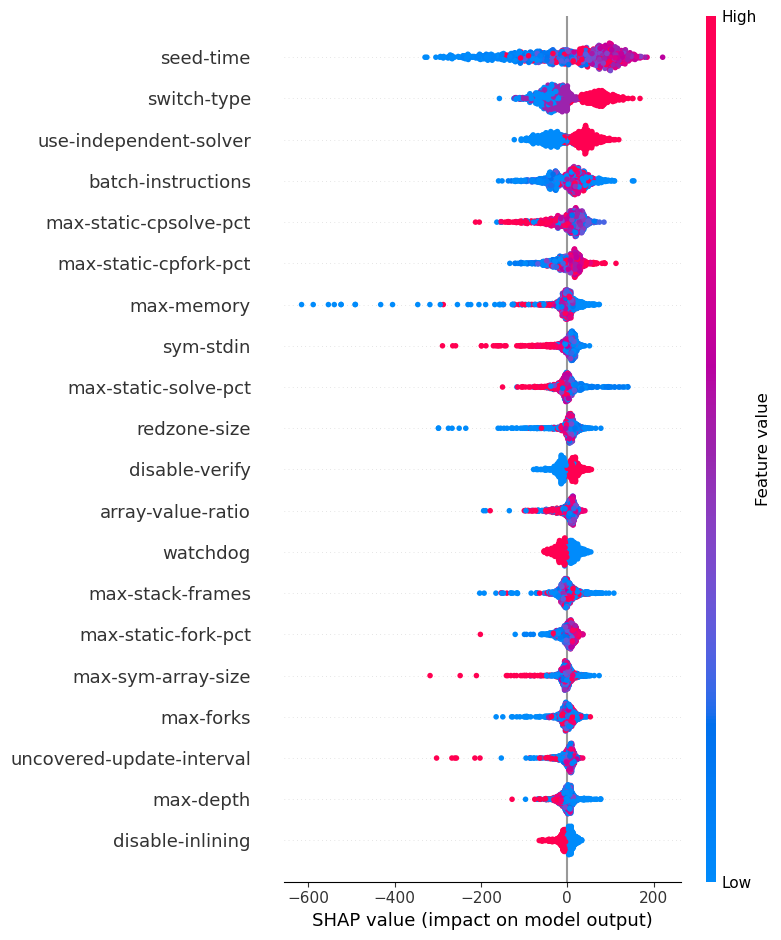

In [36]:
# 테스트 데이터에 대한 예측 수행
y_pred = model.predict(X_test)

# SHAP 값 계산
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# SHAP 요약 플롯 생성
shap.summary_plot(shap_values, X)

Model R^2 score: 0.035


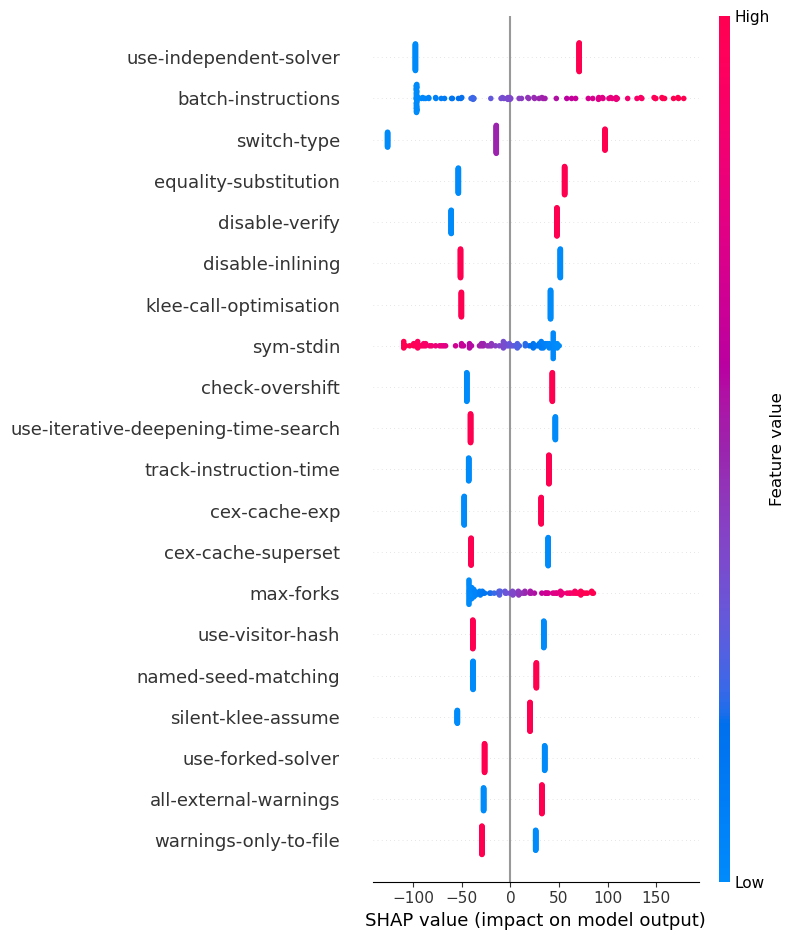

In [38]:
from sklearn.linear_model import LinearRegression
# 선형 회귀 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

# 모델 예측 성능 평가
score = model.score(X_test, y_test)
print(f'Model R^2 score: {score:.3f}')

# 테스트 데이터에 대한 예측 수행
y_pred = model.predict(X_test)

# SHAP 값 계산
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# SHAP 요약 플롯 생성
shap.summary_plot(shap_values, X_test)

In [40]:
import shap
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=200, random_state=1)
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

print(regr.predict(X_test[:2]))
print(regr.score(X_test, y_test))

explainer = shap.KernelExplainer(model=regr.predict, data=X_train, link="identity")
shap_values = explainer.shap_values(X_test, nsamples=100)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test[:1])

/opt/anaconda3/envs/swt/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
Using 757 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


[1276.1843688  1859.17738963]
-1.0182115571281685


100%|██████████| 106/106 [00:54<00:00,  1.93it/s]


In [42]:
print(regr.score(X_test, y_test))

-1.0182115571281685
